# Day 5: Classification for Trading Signals
## Week 4: Machine Learning Foundations

---

### 🎯 Learning Objectives
- Frame trading as a classification problem
- Implement logistic regression and tree models
- Handle class imbalance
- Evaluate with appropriate metrics

---

### 📈 Why Classification for Trading?

**Regression predicts exact returns (hard)**
**Classification predicts direction (easier)**

For trading, direction is often more important than magnitude.

### Trading Applications

| Target Type | Example | Use Case |
|-------------|---------|----------|
| **Binary** | Up/Down | Simple long/short |
| **Multi-class** | Strong Up/Up/Flat/Down/Strong Down | Position sizing |
| **Probability** | P(Up) = 0.65 | Confidence-weighted trades |

### 🎯 Why Classification Can Beat Regression

| Advantage | Explanation |
|-----------|-------------|
| Simpler target | 0/1 easier than continuous |
| Robust to outliers | Extreme returns don't dominate |
| Actionable output | Directly maps to buy/sell |
| Better metrics | Accuracy, precision meaningful |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)

prices = data['Close'].dropna()
print(f"✅ Data loaded: {prices.shape[0]} days")

returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. Framing as Classification

### 🎯 Converting Returns to Classes

Instead of predicting exact returns, predict:
- **Binary**: Up (1) or Down (0)
- **Multi-class**: Strong up, Up, Flat, Down, Strong down

### Target Definition Options

| Definition | Threshold | Use Case |
|------------|-----------|----------|
| Simple sign | Return > 0 | Basic direction |
| With buffer | \|Return\| > 0.5% | Avoid noise |
| Terciles | Top/Mid/Bottom 33% | Relative performance |
| Risk-adjusted | Sharpe > 0 | Quality of return |

### Class Imbalance in Finance

**Markets have a slight upward bias:**
- ~52-53% of days are "up" days
- This is actually pretty balanced
- Much better than fraud detection (99/1 imbalance)

### Trading Decision Matrix

| Predicted | Actual Up | Actual Down |
|-----------|-----------|-------------|
| Up (Long) | ✅ Profit | ❌ Loss |
| Down (Short) | ❌ Loss | ✅ Profit |

In [2]:
# Create binary target
print("=" * 60)
print("CREATING CLASSIFICATION TARGET")
print("=" * 60)

# Binary classification: next day return > 0
target = (returns['MSFT'] > 0).astype(int)

print(f"\nClass distribution:")
print(f"  Down (0): {(target == 0).sum()} ({(target == 0).mean():.1%})")
print(f"  Up (1):   {(target == 1).sum()} ({(target == 1).mean():.1%})")

# Create features
def create_features(returns, prices, target_col):
    """Create feature matrix for classification."""
    features = pd.DataFrame(index=returns.index)
    
    # Lagged returns
    for lag in range(1, 6):
        features[f'ret_lag_{lag}'] = returns[target_col].shift(lag)
    
    # Technical features
    p = prices[target_col]
    r = returns[target_col]
    
    # SMA position
    for w in [5, 10, 20]:
        features[f'above_sma_{w}'] = (p > p.rolling(w).mean()).astype(int).shift(1)
        features[f'sma_dist_{w}'] = (p / p.rolling(w).mean() - 1).shift(1)
    
    # Volatility
    features['vol_5'] = r.rolling(5).std().shift(1)
    features['vol_20'] = r.rolling(20).std().shift(1)
    
    # RSI
    delta = p.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    # Momentum
    features['mom_5'] = p.pct_change(5).shift(1)
    features['mom_20'] = p.pct_change(20).shift(1)
    
    # Cross-asset
    for col in returns.columns:
        if col != target_col:
            features[f'{col}_ret_lag1'] = returns[col].shift(1)
    
    return features

X = create_features(returns, prices, 'MSFT')
y = target

# Align and clean
data = X.join(y.rename('target')).dropna()
X = data.drop('target', axis=1)
y = data['target']

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {len(X)}")

CREATING CLASSIFICATION TARGET

Class distribution:
  Down (0): 601 (47.9%)
  Up (1):   654 (52.1%)

Features: 20
Samples: 1235


## 2. Logistic Regression

### 🎯 The Baseline Classifier for Trading

**Why start with logistic regression?**
- Simple, interpretable
- Fast to train
- Outputs probabilities
- Hard to overfit

### Trading Interpretation

| Output | Interpretation | Action |
|--------|----------------|--------|
| P(Up) > 0.5 | More likely to go up | Long |
| P(Up) < 0.5 | More likely to go down | Short or flat |
| P(Up) ≈ 0.5 | Uncertain | No trade |

### Using Probability for Position Sizing

| Probability | Confidence | Position Size |
|-------------|------------|---------------|
| 0.5-0.55 | Low | 25% |
| 0.55-0.60 | Medium | 50% |
| 0.60-0.65 | High | 75% |
| > 0.65 | Very High | 100% |

In [3]:
# Logistic regression
print("=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
log_reg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Metrics
print(f"\nTest Set Results:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, y_prob):.4f}")

# Confusion matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Compare to baseline
baseline_acc = (y_test == 1).mean()  # Always predict up
print(f"\nBaseline (always predict 'up'): {baseline_acc:.4f}")

LOGISTIC REGRESSION

Test Set Results:
  Accuracy:  0.5182
  Precision: 0.5412
  Recall:    0.6917
  F1 Score:  0.6073
  AUC-ROC:   0.4858

Confusion Matrix:
[[36 78]
 [41 92]]

Baseline (always predict 'up'): 0.5385


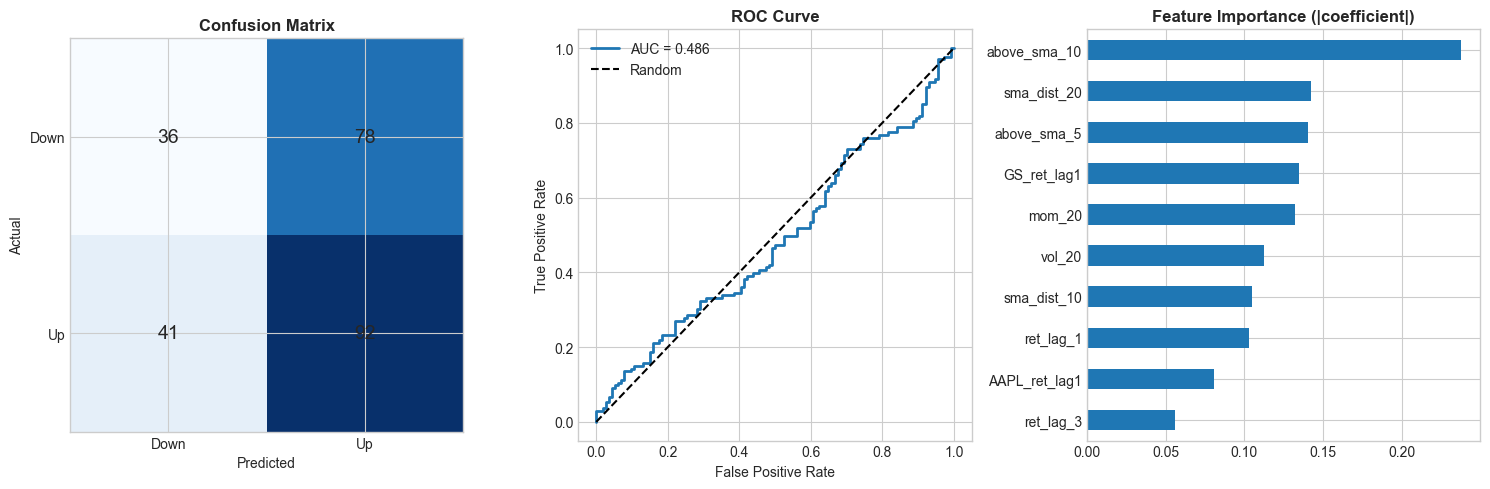

In [4]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion matrix heatmap
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Down', 'Up'])
axes[0].set_yticklabels(['Down', 'Up'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm[i, j], ha='center', va='center', fontsize=14)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()

# Feature importance
importance = pd.Series(np.abs(log_reg.coef_[0]), index=X.columns).sort_values(ascending=True)
importance.tail(10).plot(kind='barh', ax=axes[2])
axes[2].set_title('Feature Importance (|coefficient|)', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Tree-Based Models

### Tree Models for Trading

**Advantages:**
- Capture non-linear patterns
- Handle feature interactions automatically
- Don't require scaling
- Feature importance built-in

**Disadvantages:**
- Prone to overfitting
- Harder to interpret
- May not extrapolate well

### 🎯 When to Use Trees vs Logistic

| Model | Strengths | Weaknesses |
|-------|-----------|------------|
| **Logistic** | Simple, interpretable, probabilities | Linear decision boundary |
| **Decision Tree** | Captures interactions | Overfits easily |
| **Random Forest** | Robust, handles noise | Black box, slow |
| **Gradient Boosting** | Often best accuracy | Overfits if not tuned |

In [5]:
# Compare multiple models
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

models = {
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

results = []
for name, model in models.items():
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

MODEL COMPARISON

              Model  Accuracy  Precision   Recall       F1      AUC
Logistic Regression  0.518219   0.541176 0.691729 0.607261 0.485754
      Random Forest  0.514170   0.539394 0.669173 0.597315 0.471969
  Gradient Boosting  0.469636   0.507576 0.503759 0.505660 0.457130


## 4. Trading Simulation with Predictions

TRADING SIMULATION

Strategy Results by Threshold:
 Threshold  Total Return    Sharpe  Trades  % Time in Market
      0.50     -0.000003 -0.000032      74          0.688259
      0.52     -0.000743 -0.318961      92          0.603239
      0.55     -0.000555 -0.260292      93          0.404858
      0.60     -0.000880 -0.466017      53          0.141700


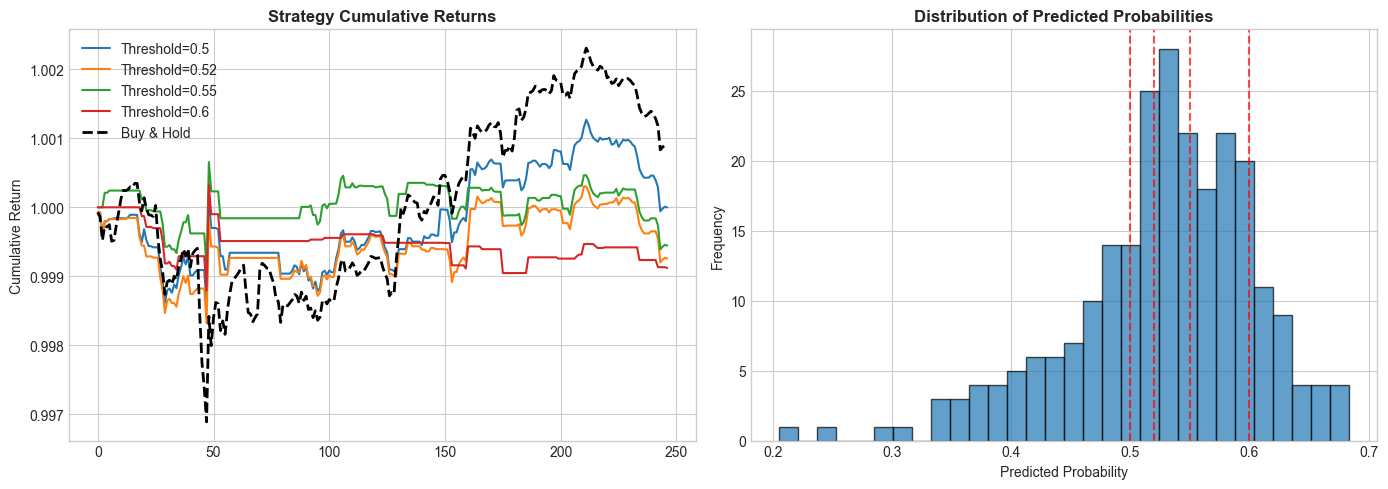

In [6]:
# Trading simulation
print("=" * 60)
print("TRADING SIMULATION")
print("=" * 60)

# Use logistic regression predictions
log_reg.fit(X_train_scaled, y_train)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Get actual returns for test period
test_returns = returns['AAPL'].loc[X_test.index]

# Strategy: Long when P(up) > threshold
thresholds = [0.5, 0.52, 0.55, 0.6]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strategy_results = []
for threshold in thresholds:
    # Position: 1 if probability > threshold, 0 otherwise
    position = (y_prob > threshold).astype(int)
    
    # Strategy return (only long when predicting up)
    strategy_return = position * test_returns.values
    
    # Cumulative returns
    cumret = (1 + strategy_return / 100).cumprod()
    
    # Metrics
    total_ret = cumret[-1] - 1
    sharpe = (strategy_return.mean() / strategy_return.std()) * np.sqrt(252)
    n_trades = (np.diff(position) != 0).sum()
    
    strategy_results.append({
        'Threshold': threshold,
        'Total Return': total_ret,
        'Sharpe': sharpe,
        'Trades': n_trades,
        '% Time in Market': position.mean()
    })
    
    axes[0].plot(cumret, label=f'Threshold={threshold}')

# Buy and hold
bh_cumret = (1 + test_returns / 100).cumprod()
axes[0].plot(bh_cumret.values, 'k--', lw=2, label='Buy & Hold')
axes[0].set_title('Strategy Cumulative Returns', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Cumulative Return')

# Results table
results_df = pd.DataFrame(strategy_results)
print("\nStrategy Results by Threshold:")
print(results_df.to_string(index=False))

# Probability distribution
axes[1].hist(y_prob, bins=30, alpha=0.7, edgecolor='black')
for t in thresholds:
    axes[1].axvline(t, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Probabilities', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Time Series Cross-Validation

In [7]:
# Time series CV
print("=" * 60)
print("TIME SERIES CROSS-VALIDATION")
print("=" * 60)

tscv = TimeSeriesSplit(n_splits=5)

cv_results = []
for name, model in models.items():
    if 'Logistic' in name:
        scores = cross_val_score(model, scaler.fit_transform(X), y, cv=tscv, scoring='roc_auc')
    else:
        scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
    
    cv_results.append({
        'Model': name,
        'Mean AUC': scores.mean(),
        'Std AUC': scores.std(),
        'Min AUC': scores.min(),
        'Max AUC': scores.max()
    })

cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation AUC Scores:")
print(cv_df.to_string(index=False))

print("\n💡 Note: AUC ~0.5 means no better than random")
print("   Even small improvements (0.52-0.55) can be profitable with good execution")

TIME SERIES CROSS-VALIDATION

Cross-Validation AUC Scores:
              Model  Mean AUC  Std AUC  Min AUC  Max AUC
Logistic Regression  0.504573 0.042876 0.452097 0.569810
      Random Forest  0.495946 0.042512 0.430516 0.548000
  Gradient Boosting  0.511404 0.037966 0.445371 0.549837

💡 Note: AUC ~0.5 means no better than random
   Even small improvements (0.52-0.55) can be profitable with good execution


## 📝 Key Takeaways - Day 5

### Classification vs Regression:
| Approach | Target | Use Case |
|----------|--------|----------|
| Regression | Exact return | Position sizing |
| Binary | Up/Down | Simple signals |
| Multi-class | Strength | Conviction levels |

### Metrics for Trading:
- **Accuracy**: Overall correct predictions
- **Precision**: When we predict up, how often correct?
- **AUC**: Overall discriminative ability
- **Profit**: Ultimate test (include costs!)

### Reality Check:
- >55% accuracy is impressive for daily returns
- AUC > 0.52 can be profitable
- Transaction costs matter A LOT

### Interview Questions:
- "How would you frame return prediction as classification?"
- "What metrics matter for a trading classifier?"
- "Why might high accuracy not mean profitability?"

## 🔴 PROS & CONS: Classification

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Classification Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 10:25

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
